# End-to-End Development of an Indonesian Twitter Emotion Classification Model Using the Indonesian-Twitter-Emotion-Dataset

##### *Author: Adinda Putri*

**Tujuan Proyek:**
Proyek ini bertujuan untuk mengembangkan, mengevaluasi, dan membandingkan kinerja model klasifikasi teks dalam emotion classification secara end-to-end, mulai dari tahap exploratory data analysis (EDA), data preprocessing, modeling, hingga validation.

**Dataset:**
Dataset yang digunakan adalah “Indonesian-Twitter-Emotion-Dataset” yang diperoleh dari GitHub meisaputri21. Dataset ini mencakup dua atribut utama, yaitu tweet sebagai teks input dan label sebagai kategori emosi yang menjadi target klasifikasi. Untuk mengatasi bahasa yang informal dan singkatan yang umum ditemukan dalam tweet, data akan diproses dengan bantuan kamus_singkatan.csv.

**Metodologi:**
1.  **Exploratory Data Analysis (EDA):** Memahami pola, distribusi, dan hubungan dalam data.
2.  **Data Preprocessing:** Menyiapkan data untuk proses pemodelan.
3.  **Modeling and Validation:** Membangun dan melatih model machine learning menggunakan pendekatan baseline dengan TF-IDF serta model deep learning dengan word embedding.
4.  **Evaluasi & Perbandingan:** Mengevaluasi kinerja model menggunakan metrik klasifikasi untuk melihat distribusi kesalahan prediksi.

# Exploratory Data Analysis (EDA)
## Indonesian Twitter Emotion Dataset

**Tujuan:** Memahami karakteristik dataset dan pola data dalam emotion classification pada tweet berbahasa Indonesia.  

**Dataset:** Indonesian-Twitter-Emotion-Dataset  
- 4403 samples, 2 features (termasuk target)  
- Target: label (kategori emosi)

In [1]:
%pip install pandas numpy matplotlib seaborn Sastrawi nltk imblearn fasttext scikit-learn tensorflow


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import importlib
import scripts.preprocess
importlib.reload(scripts.preprocess)
import re
import warnings
warnings.filterwarnings('ignore', message='.*Found unknown categories.*')
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', 
                          message='.*This Pipeline instance is not fitted yet.*',
                          category=FutureWarning)
from scripts.preprocess import *
from scripts.feature_engineer import *
from scripts.train_evaluation import *

# Styling
plt.style.use('default')
sns.set_palette("husl")

## Data Reading  

In [3]:
df = pd.read_csv('dataset/Twitter_Emotion_Dataset.csv')
df_kamus = pd.read_csv('dataset/kamus_singkatan.csv')

## Data Description 

In [4]:
df.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4401 non-null   object
 1   tweet   4401 non-null   object
dtypes: object(2)
memory usage: 68.9+ KB


In [6]:
df.shape

(4401, 2)

In [7]:
df.dtypes

label    object
tweet    object
dtype: object

## Checking Missing Values 

In [8]:
df.isna().sum()

label    0
tweet    0
dtype: int64

## Checking Duplicate Values 

In [9]:
print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 11


## Target Definition

Pada penelitian ini, kolom label ditetapkan sebagai variabel target karena berisi kategori emosi yang ingin diprediksi. Sementara itu, kolom tweet digunakan sebagai variabel input (fitur) yang menjadi sumber informasi teks untuk proses klasifikasi emosi.

In [10]:
X = df['tweet']
y = df['label']

print("Contoh input (X):")
print(X.head())

print("\nContoh target (y):")
print(y.head())

Contoh input (X):
0    Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...
1    Sesama cewe lho (kayaknya), harusnya bisa lebi...
2    Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3    Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...
4    Sharing pengalaman aja, kemarin jam 18.00 bata...
Name: tweet, dtype: object

Contoh target (y):
0    anger
1    anger
2    happy
3    anger
4    happy
Name: label, dtype: object


## Univariate Analysis 

### Data Distribution and Data Visualization for Each Feature 

In [11]:
print("Kolom Label")

print(f"Unique values dalam target: {sorted(df['label'].unique())}")
print(df['label'].value_counts())

Kolom Label
Unique values dalam target: ['anger', 'fear', 'happy', 'love', 'sadness']
label
anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: count, dtype: int64


Analisis univariat pada kolom label menunjukkan bahwa dataset terdiri dari lima kategori emosi, yaitu anger, fear, happy, love, dan sadness. Distribusi data relatif seimbang pada kelas anger, happy, dan sadness, sementara kelas fear dan love memiliki jumlah sampel lebih sedikit. Informasi ini sangat penting karena ketidakseimbangan distribusi label dapat memengaruhi kinerja model klasifikasi sehingga perlu dipertimbangkan dalam tahap pra-pemrosesan dan pemodelan.

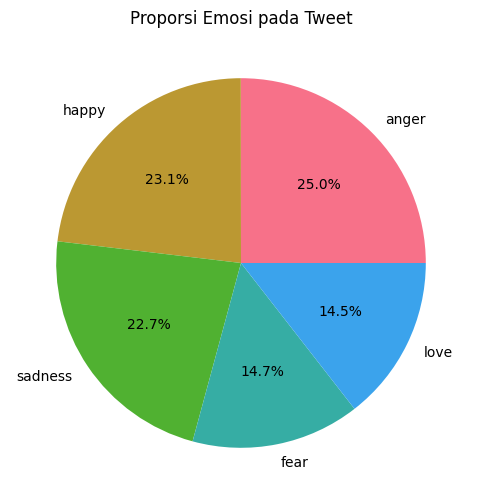

In [12]:
# Pie chart distribusi emosi
plt.figure(figsize=(6,6))
df['label'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Proporsi Emosi pada Tweet")
plt.ylabel("")
plt.show()

Selanjutnya, dilakukan analisis pada kolom tweet untuk melihat distribusi jumlah kata serta mengidentifikasi kata-kata yang paling sering muncul. Analisis ini bertujuan untuk menemukan kata-kata anomali seperti username, yang kurang relevan sehingga dapat dipertimbangkan untuk dihapus pada tahap preprocessing.

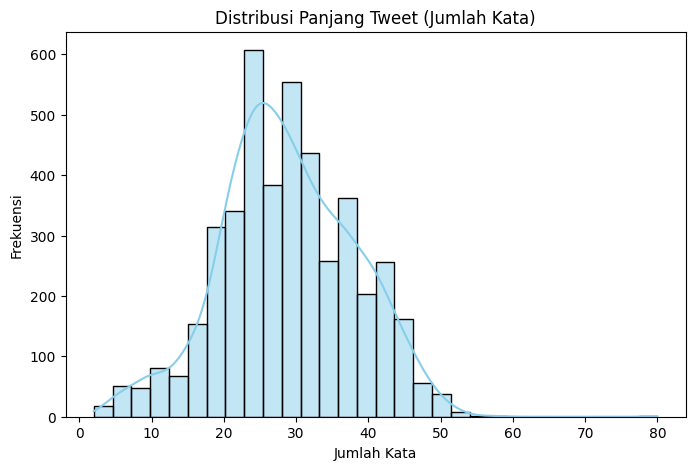

In [13]:
df['word_count'] = df['tweet'].apply(lambda x: len(x.split())) 

plt.figure(figsize=(8,5))
sns.histplot(df['word_count'], bins=30, kde=True, color="skyblue")
plt.title("Distribusi Panjang Tweet (Jumlah Kata)")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

df = df.drop('word_count', axis=1)

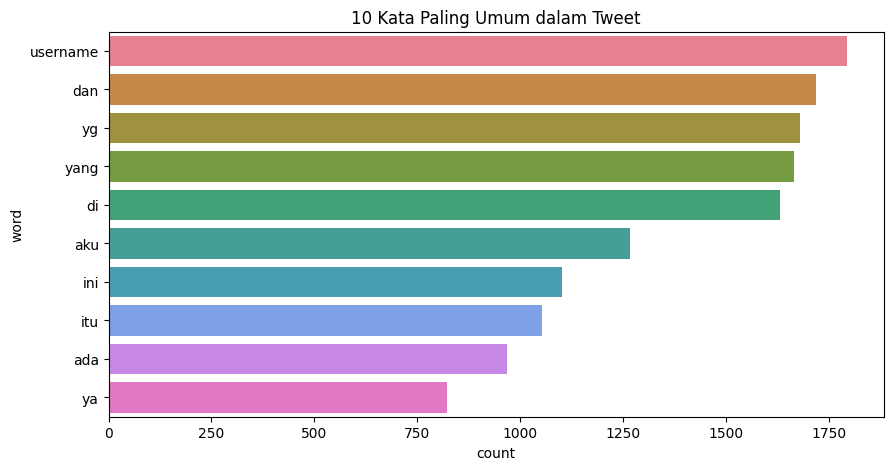

In [14]:
all_words = re.findall(r'\b\w+\b', ' '.join(df['tweet']).lower()) 
common_words = Counter(all_words).most_common(10)

common_df = pd.DataFrame(common_words, columns=['word','count'])
plt.figure(figsize=(10,5))
sns.barplot(data=common_df, x='count', y='word', hue="word", palette="husl")
plt.title("10 Kata Paling Umum dalam Tweet")
plt.show()

## Data Preprocessing

Data preprocessing meliputi case folding, penghapusan informasi tidak relevan, normalisasi singkatan dengan kamus_singkatan.csv, stemming menggunakan Sastrawi, penghapusan stop words, serta data splitting menjadi data training, validation, dan testing.

### Informasi Duplicate Values
Untuk kemudahan analisis, ditampilkan kembali informasi mengenai duplicate values

In [15]:
print(f"Jumlah duplikat sebelum: {df.duplicated().sum()}")

Jumlah duplikat sebelum: 11


### Handle Duplicate Values

In [16]:
df = df.drop_duplicates()
print(f"Jumlah duplikat sesudah: {df.duplicated().sum()}")

Jumlah duplikat sesudah: 0


### Data Preprocessing and Data Splitting

Preprocessing untuk model baseline dilakukan melalui beberapa tahapan, yaitu mengubah seluruh teks menjadi huruf kecil, membersihkan karakter tertentu, melakukan normalisasi kata, menghapus spasi berlebih, melakukan stemming, memecah teks menjadi token kata, serta menghapus stopwords dengan tetap menyaring token yang panjangnya lebih dari satu karakter.

In [17]:
baseline_splits = preprocess_for_baseline_models(df)
print("10 tweet pertama dari data train baseline setelah preprocessing:")
print(baseline_splits['train']['tweet'].head(10))

10 tweet pertama dari data train baseline setelah preprocessing:
1015    puasa badan kurus lebar klimaks pas raya gemuk ya
1433    self titled bin idris mas haikal cs jago bikin...
1815    pergi jalan bebat ya gin anak sulung pergi dib...
2996    libur tugas dikumpulin senin takut selesai ngi...
3068    asa minggu jumpa temu cinta hadap member bayan...
3932    wajar cowok nang gara gara tahan kangen nya ke...
2462    kadang rezeki diitung investasi sosial pjg daf...
2346                               sayang takut hilang ku
4135    takut hati sayang someone takut tinggal takut ...
1131    goblok kafir bilang masyumi vs pki zaman soeka...
Name: tweet, dtype: object


Preprocessing untuk model berbasis deep learning dilakukan dengan tahapan yang hampir sama seperti pada baseline. Namun, preprocessing pada model ini tidak menggunakan stemming maupun penghapusan stopwords. Hal ini dikarenakan model deep learning, khususnya yang menggunakan embedding membutuhkan konteks kata asli dengan mempertahankan stopwords. 

In [18]:
dl_splits = preprocess_for_deep_learning(df)
print("10 tweet pertama dari data train deep learning setelah preprocessing:")
print(dl_splits['train']['tweet'].head(10))

10 tweet pertama dari data train deep learning setelah preprocessing:
1020    minggu ketika perasaan merahasiakan kabarnya l...
1433    self titled bin idris saya tahu mas haikal cs ...
2577    pernah pada saat itu punya tipe cewek yang har...
2997    libur tapi ini tugas dikumpulin senin saya tak...
4372    nekko nya saya eh bukan nekko nya jujun baikkk...
3691    manja kang spam suka imagine perhatian sekali ...
2462    kadang rezeki kalau diitung bakal selalu ada s...
2729    saya takan ragukan besarnya kasih sayang tuhan...
4136    saya akan jadi takut bila hati saya sudah mula...
1131    memang goblok kamu ini kafir saya bilang masyu...
Name: tweet, dtype: object


## Feature Extraction

Feature Extraction pada proyek ini mengubah teks hasil preprocessing menjadi representasi numerik. Baseline models menggunakan TF-IDF untuk merepresentasikan frekuensi kata atau n-gram, sedangkan deep learning models menggunakan word embedding untuk menangkap makna antar kata.

In [19]:
baseline_features = extract_tfidf_features(baseline_splits)
print(f"TF-IDF features shape: {baseline_features['X_train'].shape}")

dl_features = extract_embedding_features(dl_splits)
print(f"Embedding features shape: {dl_features['X_train'].shape}")

TF-IDF features shape: (3072, 10000)
Embedding features shape: (3073, 300)


In [21]:
os.makedirs(MODELS_DIR, exist_ok=True)

tfidf_extractor = TFIDFFeatureExtractor()
tfidf_extractor.fit_transform(baseline_splits['train']['tweet'].tolist())

tfidf_vectorizer_path = os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl')
with open(tfidf_vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_extractor.vectorizer, f)

print("TF-IDF vectorizer saved")

TF-IDF vectorizer saved


## Feature Engineering

Feature Engineering berfokus pada pengolahan lanjutan terhadap fitur yang sudah diekstraksi, seperti meng-handle ketidakseimbangan data.

### Distribusi Kelas - Sebelum Data Balancing

In [22]:
unique_baseline, counts_baseline = np.unique(baseline_features['y_train'], return_counts=True)
unique_dl, counts_dl = np.unique(dl_features['y_train'], return_counts=True)
print(f"Baseline: {dict(zip(unique_baseline, counts_baseline))}")
print(f"Deep Learning: {dict(zip(unique_dl, counts_dl))}")

Baseline: {'anger': 770, 'fear': 452, 'happy': 708, 'love': 445, 'sadness': 697}
Deep Learning: {'anger': 770, 'fear': 452, 'happy': 709, 'love': 445, 'sadness': 697}


### TF-IDF

In [23]:
baseline_smote = balance_data(baseline_features, strategy='smote')
print(f"TF-IDF + Undersampling: {baseline_smote['X_train'].shape}")

baseline_undersampling = balance_data(baseline_features, strategy='undersampling')
print(f"TF-IDF + Undersampling: {baseline_undersampling['X_train'].shape}")

TF-IDF + Undersampling: (3850, 10000)
TF-IDF + Undersampling: (2225, 10000)


### Word Embedding

In [24]:
dl_smote = balance_data(dl_features, strategy='smote')
print(f"Embedding + SMOTE: {dl_smote['X_train'].shape}")

dl_undersampling = balance_data(dl_features, strategy='undersampling')
print(f"Embedding + Undersampling: {dl_smote['X_train'].shape}")

Embedding + SMOTE: (3850, 300)
Embedding + Undersampling: (3850, 300)


### Distribusi Kelas - Setelah Data Balancing

In [25]:
print("TF-IDF + SMOTE:", dict(zip(*np.unique(baseline_smote['y_train'], return_counts=True))))
print("TF-IDF + Undersampling:", dict(zip(*np.unique(baseline_undersampling['y_train'], return_counts=True))))


print("Embedding + SMOTE:", dict(zip(*np.unique(dl_smote['y_train'], return_counts=True))))
print("Embedding + Undersampling:", dict(zip(*np.unique(dl_undersampling['y_train'], return_counts=True))))

TF-IDF + SMOTE: {'anger': 770, 'fear': 770, 'happy': 770, 'love': 770, 'sadness': 770}
TF-IDF + Undersampling: {'anger': 445, 'fear': 445, 'happy': 445, 'love': 445, 'sadness': 445}
Embedding + SMOTE: {'anger': 770, 'fear': 770, 'happy': 770, 'love': 770, 'sadness': 770}
Embedding + Undersampling: {'anger': 445, 'fear': 445, 'happy': 445, 'love': 445, 'sadness': 445}


## Data Training and Modelling

### Baseline Model dengan TF-IDF Features

In [26]:
baseline_models_under, baseline_trainer_under = train_baseline_models(baseline_undersampling)
print(f"Trained baseline models (undersampling): {list(baseline_models_under.keys())}")

baseline_models_smote, baseline_trainer_smote = train_baseline_models(baseline_smote)
print(f"Trained baseline models (SMOTE): {list(baseline_models_smote.keys())}")

Trained baseline models (undersampling): ['multinomial_nb', 'svm_linear', 'logistic_regression']
Trained baseline models (SMOTE): ['multinomial_nb', 'svm_linear', 'logistic_regression']


### Deep Learning Model dengan Embedding Features

In [27]:
dl_models_under, dl_trainer_under = train_deep_learning_models(dl_undersampling)
print(f"Trained DL models (undersampling): {list(dl_models_under.keys())}")

dl_models_smote, dl_trainer_smote = train_deep_learning_models(dl_smote)
print(f"Trained DL models (SMOTE): {list(dl_models_smote.keys())}")

Trained DL models (undersampling): ['feedforward_nn']
Trained DL models (SMOTE): ['feedforward_nn']


## Evaluation

### Baseline Model

In [28]:
baseline_results_under = evaluate_baseline_models(baseline_models_under, baseline_undersampling)
baseline_results_smote = evaluate_baseline_models(baseline_models_smote, baseline_smote)

### Deep Learning Model

In [29]:
dl_results_under = evaluate_deep_learning_models(dl_models_under, dl_undersampling, dl_trainer_under)
dl_results_smote = evaluate_deep_learning_models(dl_models_smote, dl_smote, dl_trainer_smote)

## Summary and Visualization

### Best Performing Model

In [30]:
summary_df = create_results_summary(baseline_results_under, baseline_results_smote, dl_results_under, dl_results_smote)
print("Model Performance Comparison:")
print(summary_df.to_string(index=False, float_format='%.4f'))

overall_best = summary_df.iloc[0]
best_baseline = summary_df[summary_df['Model_Type'] == 'baseline'].iloc[0]
best_dl = summary_df[summary_df['Model_Type'] == 'deep_learning'].iloc[0]

print("\nOverall Best Model:")
print(f"{overall_best['Algorithm']} (F1: {overall_best['F1_Score']:.4f})")

print("\nBest Baseline Model:")
print(f"{best_baseline['Algorithm']} (F1: {best_baseline['F1_Score']:.4f})")

print("\nBest Deep Learning Model:")
print(f"{best_dl['Algorithm']} (F1: {best_dl['F1_Score']:.4f})")

Model Performance Comparison:
   Model_Type           Algorithm Balance_Method  Accuracy  Precision  Recall  F1_Score
     baseline logistic_regression          smote    0.6282     0.6381  0.6282    0.6292
     baseline          svm_linear  undersampling    0.6176     0.6203  0.6176    0.6160
deep_learning      feedforward_nn          smote    0.6115     0.6101  0.6115    0.6094
     baseline logistic_regression  undersampling    0.6131     0.6109  0.6131    0.6089
     baseline          svm_linear          smote    0.6070     0.6188  0.6070    0.6082
deep_learning      feedforward_nn  undersampling    0.5827     0.5823  0.5827    0.5815
     baseline      multinomial_nb          smote    0.5842     0.5915  0.5842    0.5794
     baseline      multinomial_nb  undersampling    0.5873     0.6004  0.5873    0.5787

Overall Best Model:
logistic_regression (F1: 0.6292)

Best Baseline Model:
logistic_regression (F1: 0.6292)

Best Deep Learning Model:
feedforward_nn (F1: 0.6094)


### Confusion Matrices

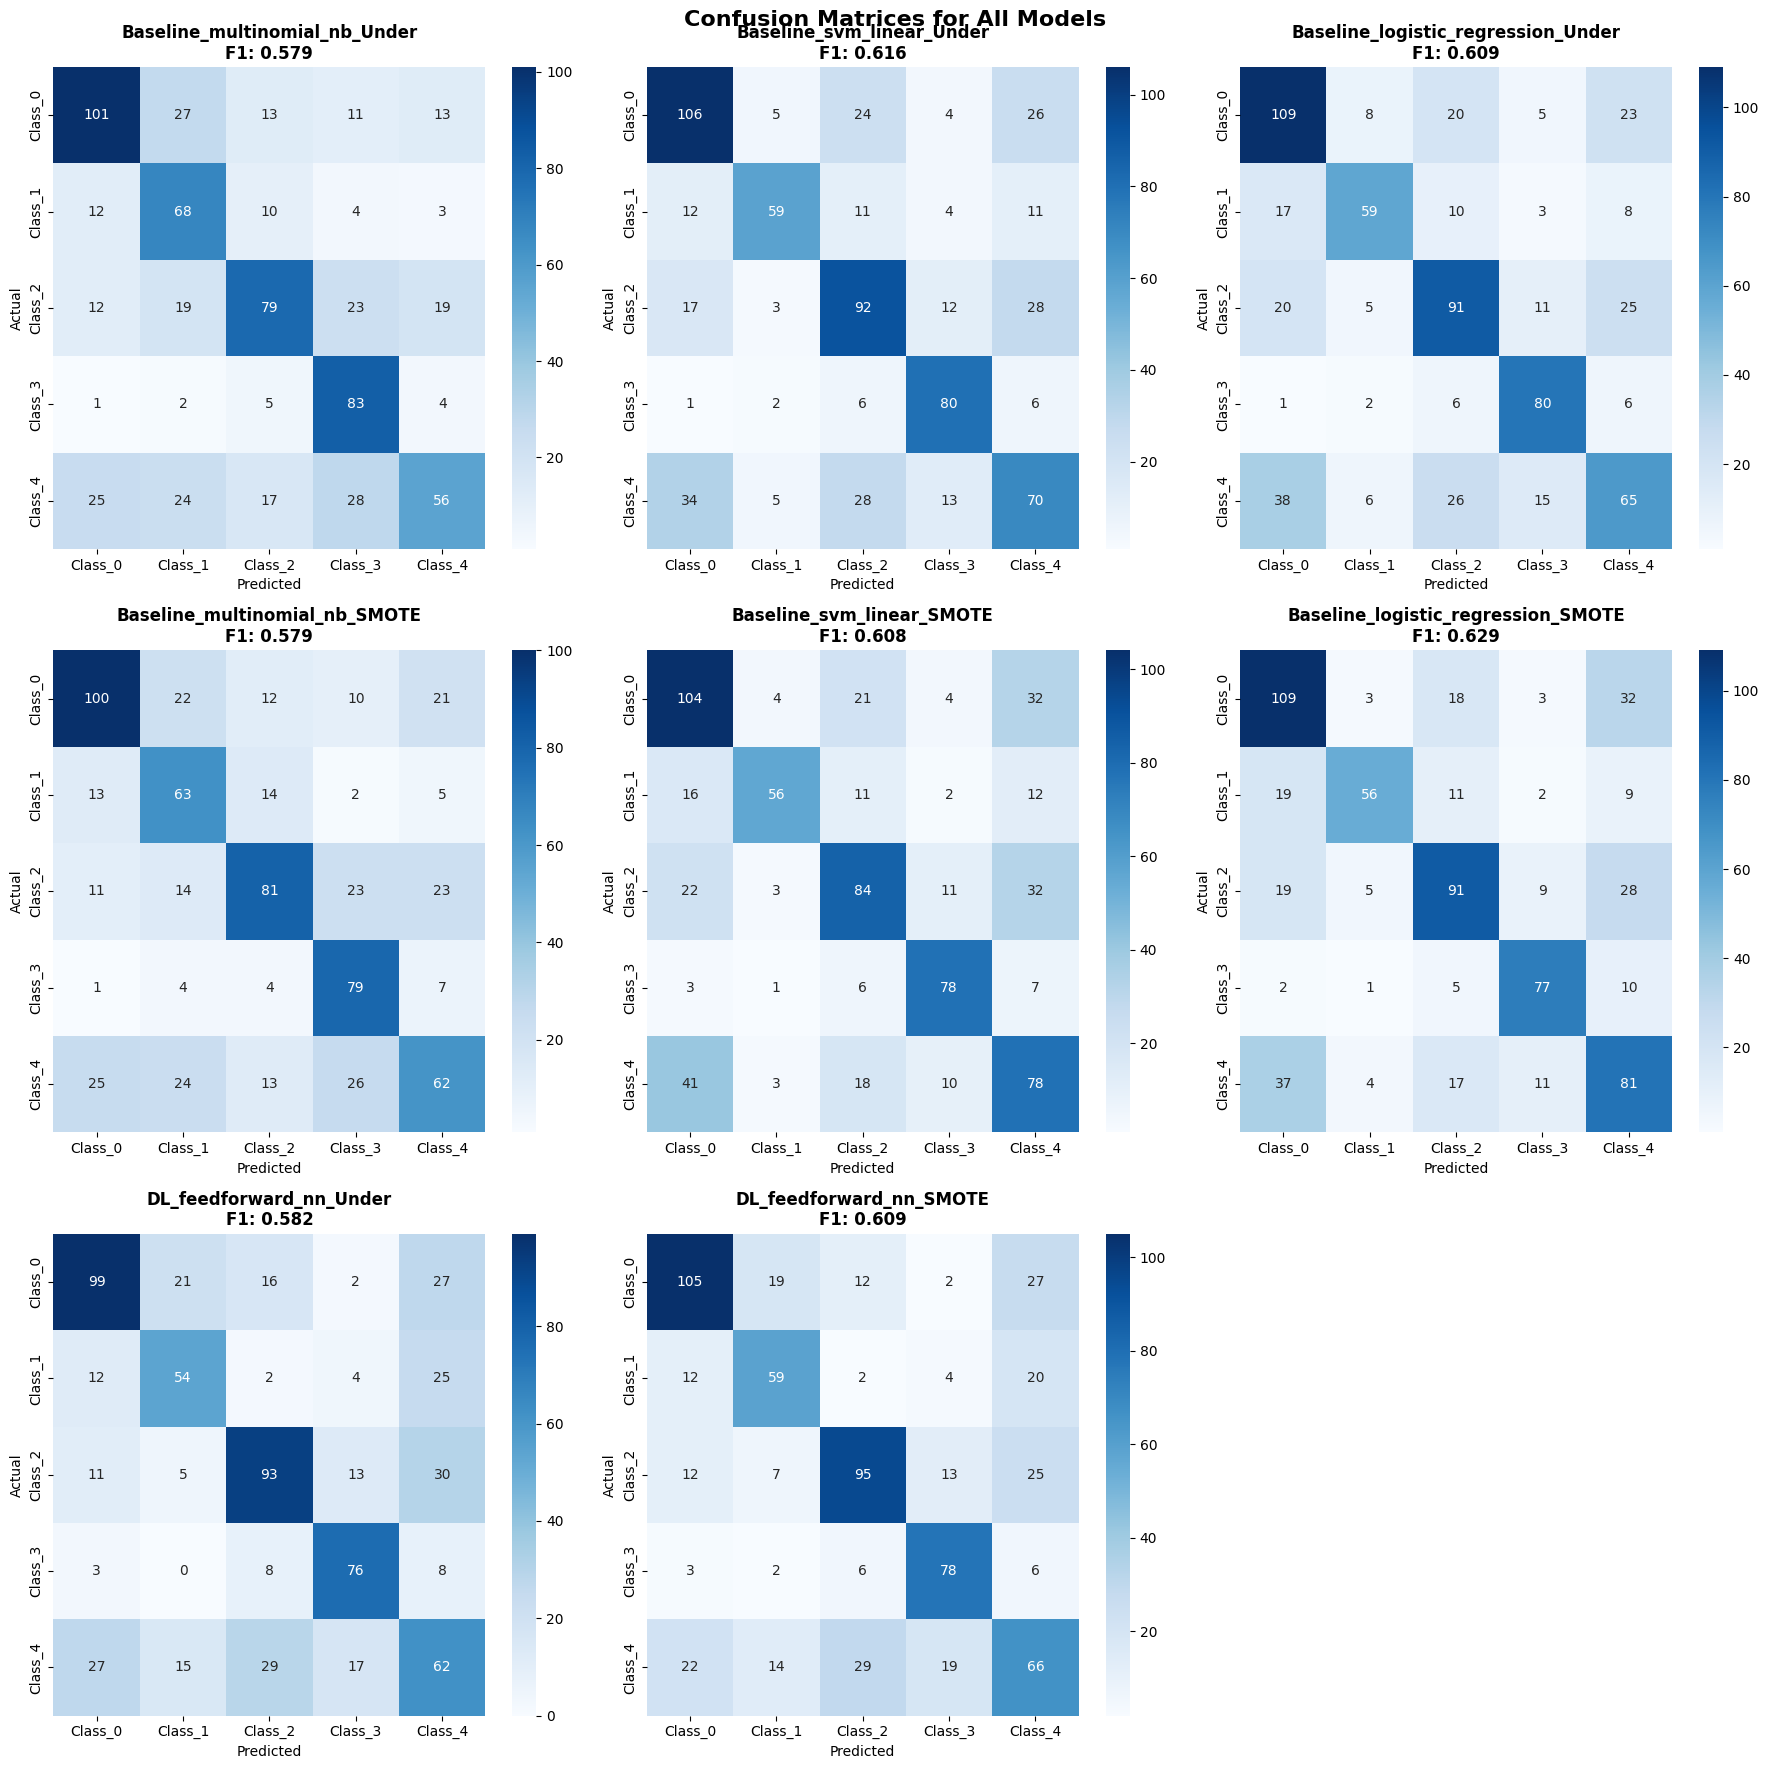

In [31]:
confusion_data = []

for model_name, metrics in baseline_results_under.items():
    confusion_data.append((f"Baseline_{model_name}_Under", metrics['confusion_matrix'], metrics['f1_score']))

for model_name, metrics in baseline_results_smote.items():
    confusion_data.append((f"Baseline_{model_name}_SMOTE", metrics['confusion_matrix'], metrics['f1_score']))

for model_name, metrics in dl_results_under.items():
    confusion_data.append((f"DL_{model_name}_Under", metrics['confusion_matrix'], metrics['f1_score']))

for model_name, metrics in dl_results_smote.items():
    confusion_data.append((f"DL_{model_name}_SMOTE", metrics['confusion_matrix'], metrics['f1_score']))

n_models = len(confusion_data)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

if n_models == 1:
    axes = [axes]
elif rows == 1:
    axes = axes.reshape(1, -1)

for idx, (model_name, cm, f1) in enumerate(confusion_data):
    row = idx // cols
    col = idx % cols
    
    if rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]
    
    labels = [f'Class_{i}' for i in range(cm.shape[0])]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'{model_name}\nF1: {f1:.3f}', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

for idx in range(n_models, rows * cols):
    row = idx // cols
    col = idx % cols
    if rows > 1:
        axes[row, col].axis('off')
    else:
        axes[col].axis('off')

plt.tight_layout()
plt.show()

### Saving Models

In [32]:
saved_paths = {}

baseline_algo = best_baseline['Algorithm']
baseline_balance = best_baseline['Balance_Method']

if baseline_balance == 'undersampling':
    model_info = baseline_trainer_under.trained_models[f"tfidf_{baseline_algo}"]
else:
    model_info = baseline_trainer_smote.trained_models[f"tfidf_{baseline_algo}"]

saved_paths['baseline'] = save_model(
    model_info['model'], 
    'best_baseline_model',
    model_info['feature_type'], 
    model_info['algorithm']
)

dl_algo = best_dl['Algorithm']
dl_balance = best_dl['Balance_Method']

if dl_balance == 'undersampling':
    model_info = dl_trainer_under.trained_models[f"embedding_{dl_algo}"]
else:
    model_info = dl_trainer_smote.trained_models[f"embedding_{dl_algo}"]

saved_paths['deep_learning'] = save_model(
    model_info, 
    'best_dl_model',
    model_info['feature_type'], 
    model_info['algorithm']
)

print(f"Models saved: {len(saved_paths)} files")
print(f"Save directory: {MODELS_DIR}")
print("Saved files:")
for key, path in saved_paths.items():
    print(f"  {key}: {os.path.basename(path)}")

Models saved: 2 files
Save directory: models
Saved files:
  baseline: best_baseline_model.pkl
  deep_learning: best_dl_model.pkl
